# Voting Regressor (CatBoost and Regularized Greedy Forest)

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from scipy import stats
from numpy import median
from sklearn import metrics
from sklearn import model_selection
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from rgf.sklearn import RGFRegressor
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings('ignore')

filename = 'train.csv' 
df_train = pd.read_csv(filename)
df_train.rename(columns={'weathersit':'weather',
                     'mnth':'month',
                     'hr':'hour',
                     'yr':'year',
                     'hum': 'humidity',
                     'cnt':'count'},inplace=True)

df_train['season'] = df_train.season.astype('category')
df_train['year'] = df_train.year.astype('category')
df_train['month'] = df_train.month.astype('category')
df_train['holiday'] = df_train.holiday.astype('category')
df_train['workingday'] = df_train.workingday.astype('category')
df_train['weather'] = df_train.weather.astype('category')

df_train['count']=df_train['count'].apply(lambda x:np.log(x))
df_train = df_train.drop(['atemp', 'casual', 'registered', 'windspeed', 'holiday'], axis=1)

df_train = df_train[df_train.weather != 4]
df_train = pd.get_dummies(df_train)
df_train = df_train.drop(df_train[['weather_4']], axis = 1)

X = df_train.loc[:, df_train.columns != 'count' ]
y = df_train['count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Grid Search CV

In [2]:
estimator = CatBoostRegressor()

param_grid = {
    'loss_function': ['RMSE'],
    'learning_rate': [0.1, 0.2],
    'n_estimators': [650, 690],
    'l2_leaf_reg': [0.7, 0.8]
}

gridcat = GridSearchCV(estimator, param_grid, cv=5, scoring = 'neg_mean_squared_error', n_jobs = -1)
gridcat.fit(X_train, y_train)

print('Best parameters found by grid search are:', gridcat.best_params_)

cat_y_pred = gridcat.predict(X_test)

cat_y_pred_exp = np.exp(cat_y_pred)
y_test_exp = np.exp(y_test)
print('RMSLE:', np.sqrt(mean_squared_log_error(y_test_exp, cat_y_pred_exp)))

0:	learn: 1.3819398	total: 58.5ms	remaining: 40.3s
1:	learn: 1.2823670	total: 61.3ms	remaining: 21.1s
2:	learn: 1.1953719	total: 64.3ms	remaining: 14.7s
3:	learn: 1.1267613	total: 67.1ms	remaining: 11.5s
4:	learn: 1.0610804	total: 69.9ms	remaining: 9.58s
5:	learn: 1.0003119	total: 72.6ms	remaining: 8.27s
6:	learn: 0.9508371	total: 75.4ms	remaining: 7.36s
7:	learn: 0.9079987	total: 78ms	remaining: 6.65s
8:	learn: 0.8605087	total: 80.7ms	remaining: 6.11s
9:	learn: 0.8183783	total: 83.3ms	remaining: 5.67s
10:	learn: 0.7869022	total: 86.1ms	remaining: 5.32s
11:	learn: 0.7593007	total: 88.7ms	remaining: 5.01s
12:	learn: 0.7373308	total: 91.5ms	remaining: 4.76s
13:	learn: 0.7177383	total: 94ms	remaining: 4.54s
14:	learn: 0.6870163	total: 96.9ms	remaining: 4.36s
15:	learn: 0.6601988	total: 99.7ms	remaining: 4.2s
16:	learn: 0.6426539	total: 102ms	remaining: 4.05s
17:	learn: 0.6234240	total: 105ms	remaining: 3.92s
18:	learn: 0.6098295	total: 108ms	remaining: 3.81s
19:	learn: 0.5893299	total: 11

In [4]:
estimator = RGFRegressor()

param_grid = {
    'algorithm': ['RGF'],
    'l2': [0.06, 0.07, 0.08],
    'max_leaf': [9000, 10000],
    'min_samples_leaf': [9, 10, 11]
}

gridrgf = GridSearchCV(estimator, param_grid, cv=5, scoring = 'neg_mean_squared_error', n_jobs = -1)
gridrgf.fit(X_train, y_train)

print('Best parameters found by grid search are:', gridrgf.best_params_)

rgf_pred = gridrgf.predict(X_test)

rgf_pred_exp = np.exp(rgf_pred)
y_test_exp = np.exp(y_test)
print('RMSLE:', np.sqrt(mean_squared_log_error(y_test_exp, rgf_pred_exp)))

Best parameters found by grid search are: {'algorithm': 'RGF', 'l2': 0.06, 'max_leaf': 9000, 'min_samples_leaf': 9}
RMSLE: 0.28513391604860694


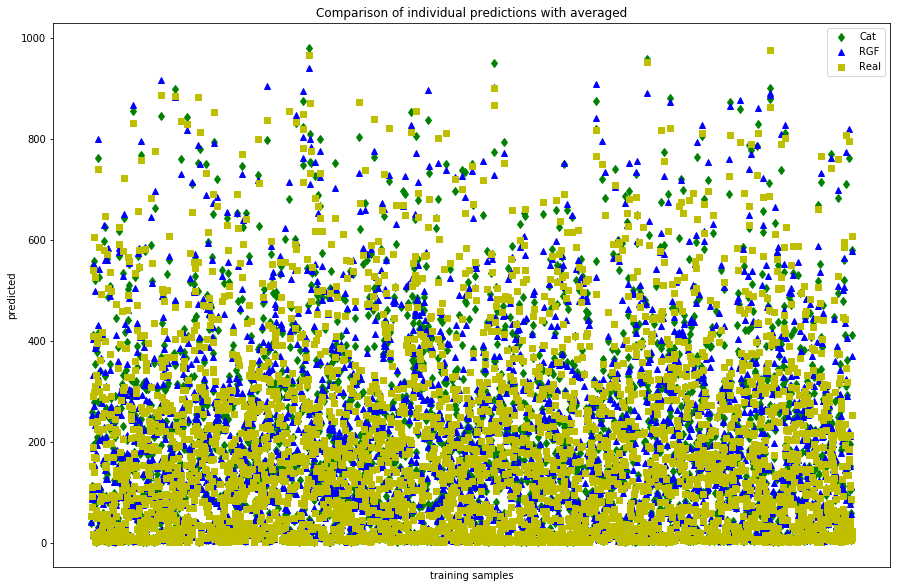

In [6]:
plt.figure(figsize = (15,10))
plt.plot(cat_y_pred_exp, 'gd', label='Cat')
plt.plot(rgf_pred_exp, 'b^', label='RGF')
plt.plot(y_test_exp.to_numpy(), 'ys', label='Real')

plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted')
plt.xlabel('training samples')
plt.legend(loc="best")
plt.title('Comparison of individual predictions with averaged')
plt.show()

### CatBoost Training

In [13]:
cat = CatBoostRegressor(silent = True,
                        loss_function='RMSE',
                        learning_rate=0.1,
                        l2_leaf_reg = 0.8,
                        n_estimators = 690)

cat.fit(X, y)

### RGF Training

In [14]:
rgf = RGFRegressor(algorithm = 'RGF', l2 = 0.06, max_leaf = 9000, min_samples_leaf = 9).fit(X, y)

### Voting Regressor

In [15]:
vr = VotingRegressor(estimators = [('rgreedyf', rgf), ('catboost', cat)], n_jobs = -1)
vr = vr.fit(X, y)

### Predictions

In [16]:
filename = 'test.csv' 
df_test = pd.read_csv(filename)

df_test.rename(columns={'weathersit':'weather',
                     'mnth':'month',
                     'hr':'hour',
                     'yr':'year',
                     'hum': 'humidity',
                     'cnt':'count'},inplace=True)

df_test['season'] = df_test.season.astype('category')
df_test['year'] = df_test.year.astype('category')
df_test['month'] = df_test.month.astype('category')
df_test['holiday'] = df_test.holiday.astype('category')
df_test['workingday'] = df_test.workingday.astype('category')
df_test['weather'] = df_test.weather.astype('category')

df_test = df_test.drop(['atemp', 'windspeed'], axis=1)
df_test = pd.get_dummies(df_test)

y_pred = vr.predict(df_test)
y_pred = np.exp(y_pred)

for i, y  in enumerate(y_pred):
    if y_pred[i] < 0:
        y_pred[i] = 0

submission = pd.DataFrame()
submission['Id'] = range(y_pred.shape[0])
submission['Predicted'] = y_pred
submission.to_csv("submission_vr.csv", index=False)

ValueError: Number of features of the model must match the input. Model n_features is 27 and input n_features is 29 